# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow -U
!pip install keras -U
!pip install keras_cv
%pwd


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

'/content'

# Keras model

In [4]:
import keras
from keras import layers as L
import keras_cv
import numpy
import cv2
keras.utils.clear_session()

#ETL ( Load data )
image_size= (128, 128)
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/cropped_faces',
    color_mode='rgb',
    interpolation="bilinear",
    image_size=image_size,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=True,
    seed=123,
    shuffle=True,
    validation_split=0.2,
    batch_size=16,
    subset='both',

)
# build a model

backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0_imagenet",
)
keras_model_classify = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=20,
    activation='softmax'
)
keras_model_classify.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
keras_model_classify.summary()

Found 1230 files belonging to 20 classes.
Using 984 files for training.
Using 246 files for validation.


100%|██████████| 1.79k/1.79k [00:00<00:00, 4.07MB/s]
100%|██████████| 23.1M/23.1M [00:00<00:00, 54.0MB/s]


Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, None, None, 1280)    │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 20)                  │          25,620 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,944,932 (22.68 MB)

 Trainable params: 5,884,324 (22.45 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [5]:
log_keras_model_classify = keras_model_classify.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=([
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1),
    ]),
    epochs=200,
)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.0490 - loss: 3.0111 - val_accuracy: 0.0772 - val_loss: 2.9955 - learning_rate: 1.0000e-05
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.0791 - loss: 2.9833 - val_accuracy: 0.0935 - val_loss: 2.9642 - learning_rate: 1.0000e-05
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.0932 - loss: 2.9488 - val_accuracy: 0.1220 - val_loss: 2.9303 - learning_rate: 1.0000e-05
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.1488 - loss: 2.9110 - val_accuracy: 0.1423 - val_loss: 2.9069 - learning_rate: 1.0000e-05
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.1565 - loss: 2.8807 - val_accuracy: 0.1789 - val_loss: 2.8781 - learning_rate: 1.0000e-05
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.2070 - loss: 2.8500 - val_accuracy: 0.2236 - val_loss: 2.8440 - learning_rate: 1.0000e-05
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accura

In [6]:
keras_model_classify.save('/content/drive/MyDrive/keras_model_classify.keras')
import pickle

with open('log_keras_model_classify.pkl', 'wb') as file:
    pickle.dump(log_keras_model_classify.history, file)

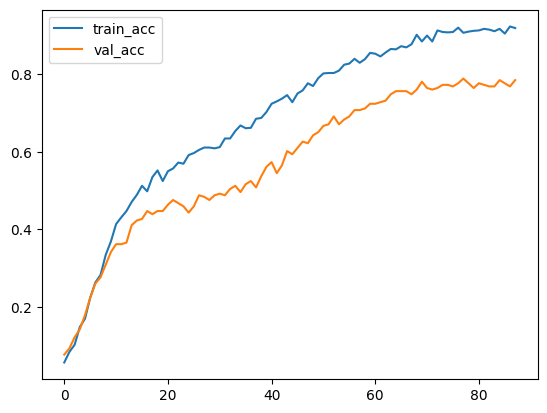

In [8]:
import matplotlib.pyplot as plt
plt.plot(log_keras_model_classify.history['accuracy'], label='train_acc')
plt.plot(log_keras_model_classify.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [9]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


# Make sure we are able to handle large datasets
import resource

low, high = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (high, high))

import tensorflow as tf

import keras
from keras import ops
from keras import layers

In [10]:
# model classifyer with labeled data
# keras_model = keras.models.load_model('/content/drive/MyDrive/my_model.keras')

# Hyperparameter setup


In [11]:
# Dataset hyperparameters
# unlabeled_dataset_size = 100000
# labeled_dataset_size = 5000
# image_channels = 3

# Algorithm hyperparameters
num_epochs = 20
batch_size = 168  # Corresponds to 200 steps per epoch
width = 128
temperature = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2} # stroing augamntion
classification_augmentation = { # weak augomantion
    "min_area": 0.75,
    "brightness": 0.3,
    "jitter": 0.1,
}

# Dataset

In [12]:
labeled_train_dataset, test_dataset = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/cropped_faces",
    color_mode="rgb",
    image_size=image_size,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=True,
    interpolation="bilinear",
    seed=123,
    shuffle=True,
    validation_split=0.2,
    subset='both',
    batch_size=8,
)

unlabeled_train_dataset  = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/cropped_faces_no_labeled",
    color_mode="rgb",
    image_size=image_size,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=True,
    interpolation="bilinear",
    seed=123,
    shuffle=True,
    batch_size=160,
    label_mode=None
)
unlabeled_train_dataset = tf.data.Dataset.zip(
    unlabeled_train_dataset, tf.data.Dataset.range(500).batch(500).repeat())

train_dataset = tf.data.Dataset.zip((unlabeled_train_dataset , labeled_train_dataset)).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1230 files belonging to 20 classes.
Using 984 files for training.
Using 246 files for validation.
Found 449 files.


# Self-supervised model for contrastive pretraining


In [13]:
# Distorts the color distibutions of images
import math


class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.seed_generator = keras.random.SeedGenerator(1337)
        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = ops.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + keras.random.uniform(
                (batch_size, 1, 1, 1),
                minval=-self.brightness,
                maxval=self.brightness,
                seed=self.seed_generator,
            )
            # Different for all colors
            jitter_matrices = keras.random.uniform(
                (batch_size, 1, 3, 3),
                minval=-self.jitter,
                maxval=self.jitter,
                seed=self.seed_generator,
            )

            color_transforms = (
                ops.tile(ops.expand_dims(ops.eye(3), axis=0), (batch_size, 1, 1, 1))
                * brightness_scales
                + jitter_matrices
            )
            images = ops.clip(ops.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )

### visualiztion


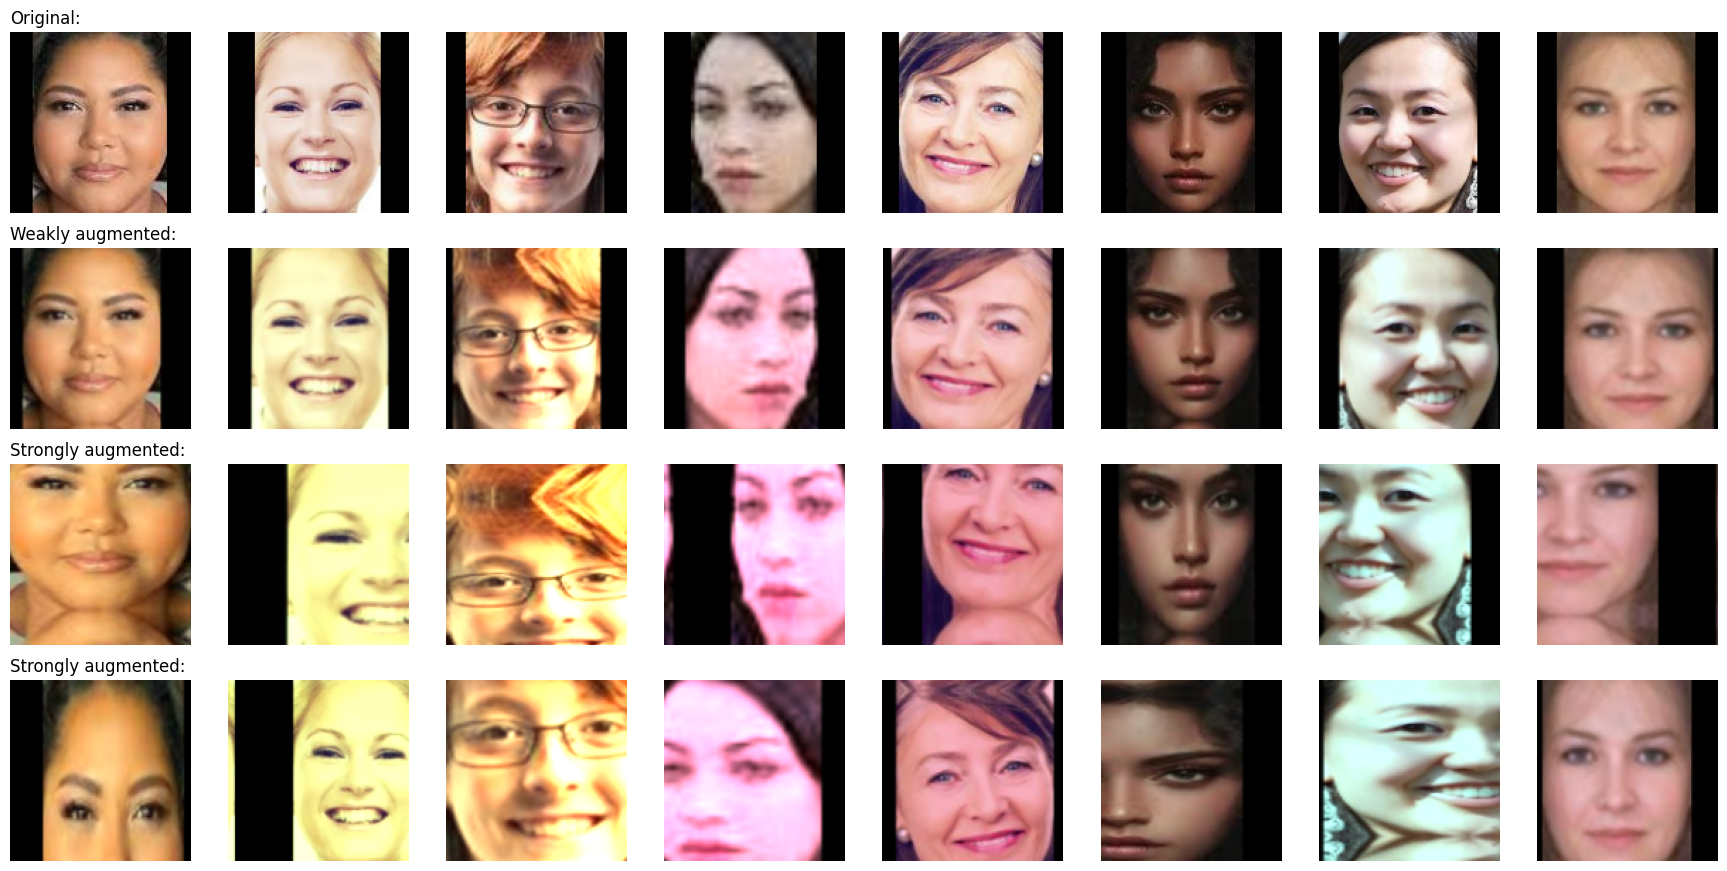

In [14]:
from matplotlib import pyplot as plt


def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset.take(1)))[0][0][:num_images].numpy().astype('uint')

    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

# Supervised baseline model


In [15]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        get_augmenter(**classification_augmentation),
        keras_model_classify.backbone,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(20),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset,
    callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1),
    ]
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 178ms/step - acc: 0.4031 - loss: 2.0317 - val_acc: 0.6179 - val_loss: 1.3158 - learning_rate: 0.0010
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - acc: 0.6494 - loss: 1.1397 - val_acc: 0.8089 - val_loss: 0.6719 - learning_rate: 0.0010
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 35s 147ms/step - acc: 0.7811 - loss: 0.7370 - val_acc: 0.8293 - val_loss: 0.5775 - learning_rate: 0.0010
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - acc: 0.8084 - loss: 0.5929 - val_acc: 0.8130 - val_loss: 0.7174 - learning_rate: 0.0010
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - acc: 0.8639 - loss: 0.4483 - val_acc: 0.8821 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - acc: 0.8847 - loss: 0.3971 - val_acc: 0.8780 - val_loss: 0.5113 - learning_rate: 0.0010
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - acc: 0.9169 - loss: 0.2292 - val_acc: 0.8293 - val_loss: 0.6969 - learnin

In [16]:
baseline_model.save('/content/drive/MyDrive/baseline_model.keras')
import pickle

with open('baseline_history.pkl', 'wb') as file:
    pickle.dump(baseline_history.history, file)


In [17]:
def get_encoder(file_path='/content/drive/MyDrive/baseline_model.keras'):
    encoder = keras.models.load_model(
        file_path,
        custom_objects={
        'RandomColorAffine': RandomColorAffine,
        },
    )
    return keras.models.Sequential(encoder.layers[1:-1])

# Self-supervised model for contrastive pretraining


In [19]:
keras.utils.clear_session()
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(1024,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(1024,)), layers.Dense(20)],
            name="linear_probe",
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = ops.normalize(projections_1, axis=1)
        projections_2 = ops.normalize(projections_2, axis=1)
        similarities = (
            ops.matmul(projections_1, ops.transpose(projections_2)) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = ops.shape(projections_1)[0]
        contrastive_labels = ops.arange(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, ops.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, ops.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = ops.concatenate((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset,

)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficient_net_v2b0_backbone          │ (None, 4, 4, 1280)          │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,231,056 (27.58 MB)

 Trainable params: 7,170,448 (27.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 147,712 (577.00 KB)

 Trainable params: 147,712 (577.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "linear_probe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 20)                  │          20,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,500 (80.08 KB)

 Trainable params: 20,500 (80.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - c_acc: 0.1405 - c_loss: 4.3285 - p_acc: 0.0573 - p_loss: 3.2243 - val_p_acc: 0.1016 - val_p_loss: 3.1421
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - c_acc: 0.1936 - c_loss: 3.5893 - p_acc: 0.1250 - p_loss: 3.1990 - val_p_acc: 0.1911 - val_p_loss: 2.5954
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - c_acc: 0.2671 - c_loss: 3.2443 - p_acc: 0.4010 - p_loss: 2.0094 - val_p_acc: 0.3455 - val_p_loss: 2.1539
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - c_acc: 0.3055 - c_loss: 2.8931 - p_acc: 0.5208 - p_loss: 1.7239 - val_p_acc: 0.4268 - val_p_loss: 1.8534
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - c_acc: 0.3580 - c_loss: 2.6096 - p_acc: 0.7344 - p_loss: 0.9334 - val_p_acc: 0.4919 - val_p_loss: 1.6665
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - c_acc: 0.4457 - c_loss: 2.3336 - p_acc: 0.7865 - p_loss: 0.9843 - val_p_acc: 0.5407 - val_p_loss: 1.5527
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - c_acc: 0.4237 - c_loss: 2.

In [20]:
pretraining_model.save('/content/drive/MyDrive/pretraining_model.keras')
import pickle

with open('pretraining_history.pkl', 'wb') as file:
    pickle.dump(pretraining_history.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


# Supervised finetuning of the pretrained encoder

In [24]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(20),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset,

)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 66s 153ms/step - acc: 0.7325 - loss: 1.0114 - val_acc: 0.8821 - val_loss: 0.4093
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - acc: 0.9541 - loss: 0.1548 - val_acc: 0.8902 - val_loss: 0.4386
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - acc: 0.9635 - loss: 0.1525 - val_acc: 0.8659 - val_loss: 0.6641
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - acc: 0.9396 - loss: 0.1953 - val_acc: 0.8902 - val_loss: 0.5089
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 246ms/step - acc: 0.9301 - loss: 0.1940 - val_acc: 0.8943 - val_loss: 0.5447
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - acc: 0.9608 - loss: 0.1244 - val_acc: 0.8740 - val_loss: 0.8943
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - acc: 0.9641 - loss: 0.1903 - val_acc: 0.8740 - val_loss: 0.5619
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - acc: 0.9573 - loss: 0.1446 - val_acc: 0.8740 - val_loss: 0.6281
Epoch 9/20
123/123 ━━━━━━━━━━━━━

In [25]:
finetuning_model.save('/content/drive/MyDrive/finetuning_model.keras')
import pickle

with open('finetuning_history.pkl', 'wb') as file:
    pickle.dump(finetuning_history.history, file)

# Comparison against the baseline

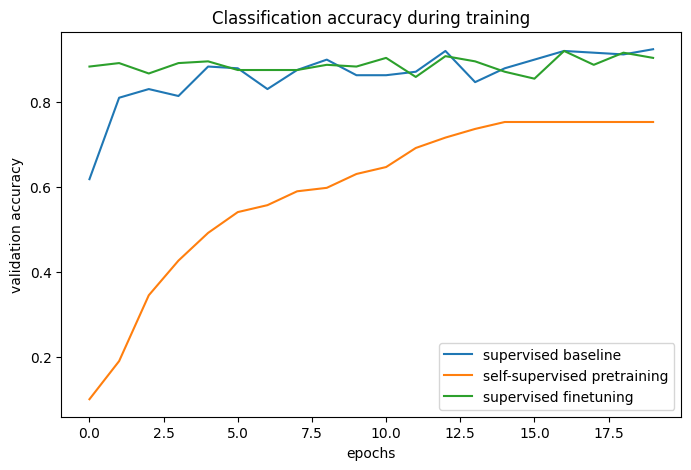

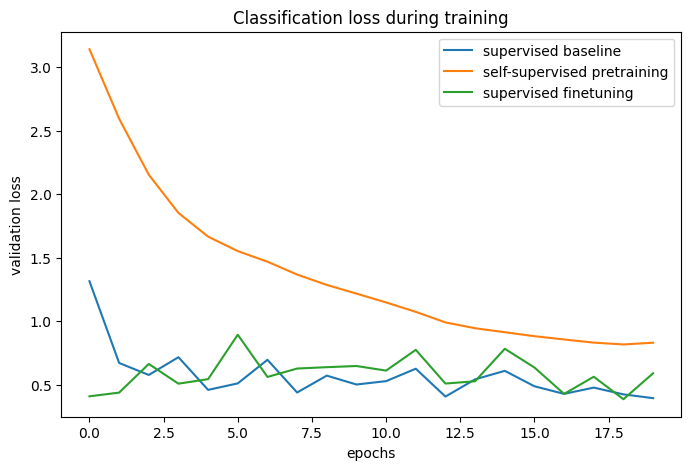

In [26]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"],
            label="supervised baseline",
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

In [32]:
import numpy as np
import cv2
img = cv2.imread('/content/drive/MyDrive/cropped_faces/cristiano_ronaldo/image102.jpg')
img_resize = cv2.resize(img, (128, 128))
img = np.expand_dims(img_resize, axis=0)
print(img.shape)



(1, 128, 128, 3)


In [46]:
class_names = train_ds.class_names
class_names

['Adel_ALjuber',
 'Dahom999',
 'Junling, Yan_Goalkeeper',
 'Lee_Dong_gook_player',
 'Liu_Dianzuo_Goalkeeper',
 'Mohamed_Nour',
 'Park_Ji_sung_player',
 'Saud Alfasal',
 'Shah_Rukh_Khan',
 'Shong_',
 'Son_Heung_player',
 'alwaled bn talal',
 'cristiano_ronaldo',
 'elon musk',
 'messi',
 'neymar',
 'salem',
 'sami_aljaber',
 'steve jobs',
 'yasser_alhuzimi']

In [45]:
labeled_train_dataset.class_names

['Adel_ALjuber',
 'Dahom999',
 'Junling, Yan_Goalkeeper',
 'Lee_Dong_gook_player',
 'Liu_Dianzuo_Goalkeeper',
 'Mohamed_Nour',
 'Park_Ji_sung_player',
 'Saud Alfasal',
 'Shah_Rukh_Khan',
 'Shong_',
 'Son_Heung_player',
 'alwaled bn talal',
 'cristiano_ronaldo',
 'elon musk',
 'messi',
 'neymar',
 'salem',
 'sami_aljaber',
 'steve jobs',
 'yasser_alhuzimi']

In [50]:
print('keras_model_classify predict is :',class_names[np.argmax(keras_model_classify.predict(img))])
print('baseline_model predict is :',class_names[np.argmax(baseline_model.predict(img))])
print('finetuning_model predict is :',class_names[np.argmax(finetuning_model.predict(img))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
keras_model_classify predict is : neymar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
baseline_model predict is : cristiano_ronaldo
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
pretraining_model predict is : cristiano_ronaldo


In [ ]:
keras_model_classify.evaluate()
